In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sparktorch import serialize_torch_obj, SparkTorch, PysparkPipelineWrapper
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import constant
import tools

# 1.Methods
## load

In [2]:
def _load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def _load_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = _load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def _load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    return sqlContext.read.csv(path, sep=",", header=True, schema=schema)


def load_files():
# to read parquet file
    settlement = _load_parquet(constant.settlement_path, constant.settlement_schema)
    settlement = settlement.dropna(subset =["VAERDI"]) \
                .withColumn("VAERDI", settlement["VAERDI"].cast("float"))
                # .where("TIME_CET like '%:00:%'")
    
    windmill = _load_csv(constant.windmill_path, constant.windmills_schema)
    windmill = windmill.where("grid != 0").fillna(0.1)
    ws10_dic = _load_weather_toPandas(constant.ws10_path)
    ws100_dic = _load_weather_toPandas(constant.ws10_path)
    wd10_dic = _load_weather_toPandas(constant.wd10_path)
    wd100_dic = _load_weather_toPandas(constant.wd100_path)
    tools.get_udf(ws10_dic, ws100_dic, wd10_dic, wd100_dic)

    return settlement, windmill

In [24]:
class NN(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    # self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.fc4 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    # x = F.tanh(self.fc3(x))
    x = self.fc4(x)

    return x

In [4]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # 128 + (26*2+3) = 183
    self.i20 = nn.Linear(input_size + hidden_size, output_size)
    # self.tanh = nn.Tanh(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1) # Concatenates
    hidden = self.i2h(combined)
    output = self.i20(combined)
    # output = self.tanh(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [5]:
class LSTM_Regression(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTM_Regression, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [6]:
def train_model(
  model, 
  lr,
  num_epochs,
  X_train, 
  y_train, 
  X_test=None, 
  y_test=None
):
  loss_fn = torch.nn.MSELoss()

  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    # model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [7]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# 2.Analysis

In [8]:
# initialise sparkContext\
spark = SparkSession.builder \
        .appName("WindTurbine_ws") \
        .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [9]:
settlement, windmill = load_files()
settlement.persist()

DataFrame[GSRN: string, VAERDI: float, TIME_CET: string]

In [10]:
windmill_s = windmill.where("Turbine_type = 'W'").sample(fraction=0.005, seed=5)

In [10]:
ls_GSRN = windmill_s.toPandas()['GSRN'].to_list()

In [11]:
ls_GSRN

['570715000000002519',
 '570715000000003837',
 '570715000000005596',
 '570715000000009457',
 '570715000000017520',
 '570715000000024580',
 '570715000000028670',
 '570715000000033025',
 '570715000000039355',
 '570715000000039386',
 '570715000000044700',
 '570715000000049873',
 '570715000000051562',
 '570715000000052002',
 '570715000000053382',
 '570715000000057281',
 '570715000000064364',
 '570715000000151040']

In [10]:
# upscaling
windmill_W = windmill.where("GSRN = '570715000000002519'")
windmill_W.persist()

DataFrame[GSRN: string, Turbine_type: string, Parent_GSRN: string, BBR_municipal: string, Placement: string, UTM_x: string, UTM_y: string, Capacity_kw: float, Rotor_diameter: float, Navhub_height: float, grid: string, grid_in_range: string, Land_cover: float, Slope: float, roughness: float]

In [11]:
train = settlement.where("TIME_CET not like '2019-03-31 02%'").where("TIME_CET not like '2019-12-30%'")
train = train.where("VAERDI > 50")
train = tools.aggregateate(train, windmill_W)

In [11]:
test = settlement.where("TIME_CET like '2019-12-30%'")
test = tools.aggregate(test, windmill_W)

In [13]:
train_pd = train.toPandas()

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:59139)

In [12]:
test_pd = test.toPandas()

In [100]:
train_pd.to_csv("570715000000002519_train.csv",index=False)

In [13]:
test_pd.to_csv("570715000000002519_test.csv",index=False)

In [18]:
spark.stop()

In [15]:
train_pd = pd.read_csv("570715000000002519_train.csv")
test_pd = pd.read_csv("570715000000002519_test.csv")

In [86]:
feat_cols = ["mins","hour","month", "roughness","Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height","ws10", "ws100","wd10","wd100"]
# feat_cols = ["mins","hour", "ws10", "ws100","wd10","wd100"]
x_train = train_pd[feat_cols]
y_train = train_pd[["VAERDI"]]
x_test = test_pd[feat_cols]
y_test = test_pd[["VAERDI"]]
timeline = test_pd[["TIME_CET"]]

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [88]:
dtype = torch.float
x_train_tensor = torch.tensor(x_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_train_tensor = torch.tensor(y_train.values, dtype = dtype)
y_test_tensor = torch.tensor(y_test.values, dtype = dtype)

In [91]:
model = NN(
  input_size=13,
  hidden_size=250,
  output_size=1
)
model, train_hist, test_hist = train_model(
  model, 
  0.3,
  300,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

Epoch 0 train loss: 10376.6142578125 test loss: 15815.1630859375
Epoch 10 train loss: 1751.990234375 test loss: 1929.67724609375
Epoch 20 train loss: 1286.3016357421875 test loss: 978.889404296875
Epoch 30 train loss: 914.1502075195312 test loss: 763.3848266601562
Epoch 40 train loss: 603.0647583007812 test loss: 500.942626953125
Epoch 50 train loss: 541.4102172851562 test loss: 439.5845642089844
Epoch 60 train loss: 514.2843627929688 test loss: 422.4783630371094
Epoch 70 train loss: 497.0760192871094 test loss: 421.375
Epoch 80 train loss: 484.5263366699219 test loss: 420.9282531738281
Epoch 90 train loss: 475.4205017089844 test loss: 423.0928039550781
Epoch 100 train loss: 468.3333740234375 test loss: 428.0945739746094
Epoch 110 train loss: 462.6210021972656 test loss: 421.9033203125
Epoch 120 train loss: 458.3493957519531 test loss: 426.2879333496094
Epoch 130 train loss: 454.2105407714844 test loss: 423.25244140625
Epoch 140 train loss: 451.544677734375 test loss: 424.041748046875


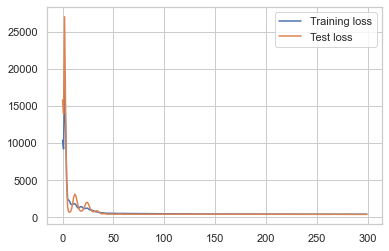

In [92]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [45]:
train_hist.tofile("train_hist.txt")
test_hist.tofile("test_hist.txt")

In [93]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().numpy()
y_test["pred"] = pd.Series(y_pred.tolist()).apply(lambda x: x[0])
y_test["time"] = pd.Series(timeline["TIME_CET"])
# y_test = y_test.groupby(y_test["time"]).agg({"VAERDI":lambda x:sum(x), "pred":lambda x:sum(x)}).reset_index()

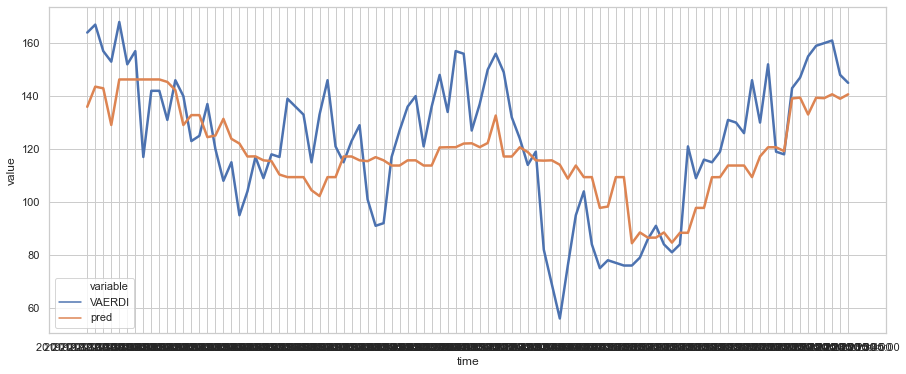

In [94]:
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(y_test, ['time']), hue='variable',linewidth=2.5)